<h1 align="center"> Image Captioning </h1>

In this notebook you will teach a network to do image captioning
![img](https://media.licdn.com/dms/image/C4D12AQH-T7BYWr9clg/article-inline_image-shrink_1500_2232/0?e=2120536800&v=alpha&t=RrGrsyl8QPtDQjdKKw6VpEbJrTq1Dnigk89_t9vhbfw)



#### Alright, here's our plan:
1. Take a pre-trained inception v3 to vectorize images
2. Stack an LSTM on top of it
3. Train the thing on [MSCOCO](http://cocodataset.org/#download)

In [1]:
# Please eithrer download data from https://yadi.sk/d/b4nAwIE73TVcp5 or generate it manually.

### Data preprocessing

In [2]:
%%time
# Read Dataset
import numpy as np
import json

img_codes = np.load("data/image_codes.npy")
captions = json.load(open('data/captions_tokenized.json'))

CPU times: user 293 ms, sys: 2.37 s, total: 2.66 s
Wall time: 4.19 s


### Data structure

To save your time, we've already vectorized all MSCOCO17 images with a pre-trained inception_v3 network from [torchvision](https://github.com/pytorch/vision/blob/master/torchvision/models/inception.py).

The whole process takes anywhere between a day on CPU and 10min on 3x tesla m40. If you want to play with that yourself, [you're welcome](https://gist.github.com/justheuristic/11fd01f9c12c0bf960499580d104130b).

In [3]:
print("Each image code is a 2048-unit vector [ shape: %s ]" % str(img_codes.shape))
print(img_codes[0,:10], end='\n\n')
print("For each image there are 5 reference captions, e.g.:\n")
print('\n'.join(captions[0]))

Each image code is a 2048-unit vector [ shape: (118287, 2048) ]
[0.3659946  0.2016555  0.9245725  0.57063824 0.547268   0.8275868
 0.3687277  0.12085301 0.0561931  0.49758485]

For each image there are 5 reference captions, e.g.:

people shopping in an open market for vegetables .
an open market full of people and piles of vegetables .
people are shopping at an open air produce market .
large piles of carrots and potatoes at a crowded outdoor market .
people shop for vegetables like carrots and potatoes at an open air market .


As you can see, all captions are already tokenized and lowercased. We now want to split them and add some special tokens for start/end of caption.

In [4]:
#split descriptions into tokens
for img_i in range(len(captions)):
    for caption_i in range(len(captions[img_i])):
        sentence = captions[img_i][caption_i] 
        captions[img_i][caption_i] = ["#START#"]+sentence.split(' ')+["#END#"]

You don't want your network to predict a million-size vector of probabilities at each step, so we're gotta make some cuts. 

We want you to __count the occurences of each word__ so that we can decide which words to keep in our vocabulary.

In [5]:
# Build a Vocabulary
from collections import Counter
word_counts = Counter()

#Compute word frequencies for each word in captions. See code above for data structure
for t1 in captions:
    for t2 in t1:
        for t3 in t2:
            word_counts[t3] += 1

In [6]:
vocab  = ['#UNK#', '#START#', '#END#', '#PAD#']
vocab += [k for k, v in word_counts.items() if v >= 5 if k not in vocab]
n_tokens = len(vocab)

assert 10000 <= n_tokens <= 10500

word_to_index = {w: i for i, w in enumerate(vocab)}

In [7]:
eos_ix = word_to_index['#END#']
unk_ix = word_to_index['#UNK#']
pad_ix = word_to_index['#PAD#']

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    max_len = max_len or max(map(len,sequences))
    
    matrix = np.zeros((len(sequences), max_len), dtype='int32') + pad_ix
    for i,seq in enumerate(sequences):
        row_ix = [word_to_index.get(word, unk_ix) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

In [8]:
#try it out on several descriptions of a random image
as_matrix(captions[1337])

array([[   1,   24,  262,  140,    6,  159,   14,   24,  858,  155,   12,
           2,    3,    3,    3,    3,    3,    3,    3],
       [   1,   24,  262,   53,   18,   24,  858,  155,    2,    3,    3,
           3,    3,    3,    3,    3,    3,    3,    3],
       [   1,   24,  262,   41,   18,  903,   35,  620,  155,    2,    3,
           3,    3,    3,    3,    3,    3,    3,    3],
       [   1,   45,  115,  262,   41,   53,   18,  620, 1525,   77,   12,
           2,    3,    3,    3,    3,    3,    3,    3],
       [   1,   24,  262,   53,   18,   24,  858,  123,   58,   45,  276,
        3641,   24, 3642,   35,   45, 1128,   12,    2]], dtype=int32)

### Building our neural network

As we mentioned earlier, we shall build an rnn "language-model" conditioned on vectors from the convolutional part. 

![img](https://raw.githubusercontent.com/yunjey/pytorch-tutorial/master/tutorials/03-advanced/image_captioning/png/model.png)
_image: http://bit.ly/2FKnqHm_


We'll unbox the inception net later to save memory, for now just pretend that it's available.


In [9]:
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

In [10]:
class CaptionNet(nn.Module):
    def __init__(self, n_tokens=n_tokens, emb_size=128, lstm_units=256, cnn_feature_size=2048):
        """ A recurrent 'head' network for image captioning. See scheme above. """
        super(self.__class__, self).__init__()
        
        # a layer that converts conv features to 
        self.cnn_to_h0 = nn.Linear(cnn_feature_size, lstm_units)
        self.cnn_to_c0 = nn.Linear(cnn_feature_size, lstm_units)
        
        # recurrent part, please create the layers as per scheme above.

        # create embedding for input words. Use the parameters (e.g. emb_size).
        self.emb = nn.Embedding(num_embeddings=n_tokens, embedding_dim=emb_size) 
            
        # lstm: create a recurrent core of your network. Use either LSTMCell or just LSTM. 
        # In the latter case (nn.LSTM), make sure batch_first=True
        self.lstm = nn.LSTM(input_size=emb_size, hidden_size=lstm_units, batch_first=True)
            
        # create logits: linear layer that takes lstm hidden state as input and computes one number per token
        self.logits = nn.Linear(in_features=lstm_units, out_features=n_tokens) 
        
    def forward(self, image_vectors, captions_ix):
        """ 
        Apply the network in training mode. 
        :param image_vectors: a Variable containing inception vectors. shape: [batch, cnn_feature_size]
        :param captions_ix: a Variable containing captions as matrix. shape: [batch, word_i]. 
            padded with pad_ix
        :returns: logits for next token at each tick, shape: [batch, word_i, n_tokens]
        """
        initial_cell = self.cnn_to_c0(image_vectors)
        initial_hid = self.cnn_to_h0(image_vectors)
        
        # compute embeddings for captions_ix
        captions_emb = self.emb(captions_ix)
        
        # apply recurrent layer to captions_emb. 
        # 1. initialize lstm state with initial_* from above
        # 2. feed it with captions. Mind the dimension order in docstring
        # 3. compute logits for next token probabilities
        # Note: if you used nn.LSTM, you can just give it (initial_cell[None], initial_hid[None]) as second arg
        
        
        # lstm_out should be lstm hidden state sequence of shape [batch, caption_length, lstm_units]
        lstm_out = self.lstm(captions_emb, (initial_cell[None], initial_hid[None]))[0]
        
        # compute logits from lstm_out
        logits = self.logits(lstm_out)
        
        return logits        

In [11]:
network = CaptionNet(n_tokens)

In [12]:
dummy_img_vec = Variable(torch.randn(len(captions[0]), 2048))
dummy_capt_ix = Variable(torch.LongTensor(as_matrix(captions[0])))

dummy_logits = network.forward(dummy_img_vec, dummy_capt_ix)

print('shape:', dummy_logits.shape)
assert dummy_logits.shape == (dummy_capt_ix.shape[0], dummy_capt_ix.shape[1], n_tokens)

shape: torch.Size([5, 16, 10403])


In [13]:
def compute_loss(network, image_vectors, captions_ix):
    """
    :param image_vectors: a Variable containing inception vectors. shape: [batch, cnn_feature_size]
    :param captions_ix: a Variable containing captions as matrix. shape: [batch, word_i]. 
        padded with pad_ix
    :returns: crossentropy (neg llh) loss for next captions_ix given previous ones. Scalar float Variable
    """
    
    # captions for input - all except last cuz we don't know next token for last one.
    captions_ix_inp = captions_ix[:, :-1].contiguous()
    captions_ix_next = captions_ix[:, 1:].contiguous()
    
    # apply the network, get predictions for captions_ix_next
    logits_for_next = network.forward(image_vectors, captions_ix_inp)
    
    
    # compute the loss function between logits_for_next and captions_ix_next
    # Use the mask, Luke: make sure that predicting next tokens after EOS do not contribute to loss
    # you can do that either by multiplying elementwise loss by (captions_ix_next != pad_ix)
    # or by using ignore_index in some losses.

    loss = F.cross_entropy(input=logits_for_next.view(logits_for_next.shape[0] * logits_for_next.shape[1],
                                                      logits_for_next.shape[2]),
                           target=captions_ix_inp.view(captions_ix_inp.shape[0] * captions_ix_inp.shape[1]),
                           ignore_index=pad_ix)
    
    return loss

In [14]:
dummy_loss = compute_loss(network, dummy_img_vec, dummy_capt_ix)

assert dummy_loss.shape == torch.Size([]), 'loss must be scalar'
assert dummy_loss.data.numpy() > 0, "did you forget the 'negative' part of negative log-likelihood"

dummy_loss.backward()

assert all(param.grad is not None for param in network.parameters()), \
        'loss should depend differentiably on all neural network weights'

Create ~~adam~~ your favorite optimizer for the network.

In [15]:
optimizer = torch.optim.Adam(network.parameters())

# Training

* First implement the batch generator
* Than train the network as usual

In [16]:
from sklearn.model_selection import train_test_split
captions = np.array(captions)
train_img_codes, val_img_codes, train_captions, val_captions = train_test_split(img_codes, captions,
                                                                                test_size=0.1,
                                                                                random_state=42)

In [17]:
from random import choice

def generate_batch(img_codes, captions, batch_size, max_caption_len=None):
    
    #sample random numbers for image/caption indicies
    random_image_ix = np.random.randint(0, len(img_codes), size=batch_size)
    
    #get images
    batch_images = img_codes[random_image_ix]
    
    #5-7 captions for each image
    captions_for_batch_images = captions[random_image_ix]
    
    #pick one from a set of captions for each image
    batch_captions = list(map(choice,captions_for_batch_images))
    
    #convert to matrix
    batch_captions_ix = as_matrix(batch_captions,max_len=max_caption_len)
    
    return Variable(torch.FloatTensor(batch_images)), Variable(torch.LongTensor(batch_captions_ix))

In [18]:
generate_batch(img_codes,captions,3)

(Variable containing:
  0.0655  0.0295  0.1805  ...   0.1079  0.2942  0.1651
  0.8052  0.1921  0.3684  ...   0.0666  1.0116  0.3614
  0.0872  0.1527  0.1685  ...   0.0000  0.0418  0.0958
 [torch.FloatTensor of size 3x2048], Variable containing:
     1    24   834   541   542    41    51    24   541   543    12     2     3
     1   652     4    35    24   541   546   170   541    12     2     3     3
     1   394  5417    58    24    21   718   717     6    45   421    12     2
 [torch.LongTensor of size 3x13])

### Main loop

Train on minibatches just as usual. Evaluate on val from time to time.

##### TIps
* If training loss has become close to 0 or model produces garbage,
    double-check that you're predicting __next__ words, not current or t+2'th words.
* If the model generates fluent captions that have nothing to do with the images
 * this may be due to recurrent net not receiving image vectors.
 * alternatively it may be caused by gradient explosion, try clipping 'em or just restarting the training
 * finally, you may just need to train the model a bit more


* Crossentropy is a poor measure of overfitting
 * Model can overfit validation crossentropy but keep improving validation quality.
 * Use human _(manual)_ evaluation or try automated metrics: [cider](https://github.com/vrama91/cider) or [bleu](https://www.nltk.org/_modules/nltk/translate/bleu_score.html)
 

* We recommend you to periodically evaluate the network using the next "apply trained model" block
 *  its safe to interrupt training, run a few examples and start training again
 
* The typical loss values should be around 3~5 if you average over time, scale by length if you sum over time. The reasonable captions began appearing at loss=2.8 ~ 3.0
 

In [19]:
batch_size = 100  # adjust me
n_epochs = 100  # adjust me
n_batches_per_epoch = 100  # adjust me
n_validation_batches = 10  # how many batches are used for validation after each epoch

In [20]:
from tqdm import tqdm

for epoch in range(n_epochs):
    train_loss=0
    network.train(True)
    for _ in range(n_batches_per_epoch):
        
        loss_t = compute_loss(network, *generate_batch(train_img_codes, train_captions, batch_size))
        
        
        # clear old gradients; do a backward pass to get new gradients; then train with opt
        
        loss_t.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        train_loss += loss_t.data.numpy()[0]
        
    train_loss /= n_batches_per_epoch
    
    val_loss=0
    network.train(False)
    for _ in range(n_validation_batches):
        loss_t = compute_loss(network, *generate_batch(val_img_codes, val_captions, batch_size))
        val_loss += loss_t.data.numpy()[0]
    val_loss /= n_validation_batches
    
    print('\nEpoch: {}, train loss: {}, val loss: {}'.format(epoch, train_loss, val_loss))

print("Finished!")


Epoch: 0, train loss: 7.830500955581665, val loss: 5.770539236068726

Epoch: 1, train loss: 5.2433309078216555, val loss: 5.026189661026001

Epoch: 2, train loss: 4.949792261123657, val loss: 4.891518259048462

Epoch: 3, train loss: 4.839988493919373, val loss: 4.778579378128052

Epoch: 4, train loss: 4.745777292251587, val loss: 4.721170139312744

Epoch: 5, train loss: 4.651017107963562, val loss: 4.625242090225219

Epoch: 6, train loss: 4.574265308380127, val loss: 4.479477119445801

Epoch: 7, train loss: 4.496606512069702, val loss: 4.462725973129272

Epoch: 8, train loss: 4.422659945487976, val loss: 4.342685842514038

Epoch: 9, train loss: 4.361710996627807, val loss: 4.290422868728638

Epoch: 10, train loss: 4.266308832168579, val loss: 4.249588680267334

Epoch: 11, train loss: 4.23796498298645, val loss: 4.192093086242676

Epoch: 12, train loss: 4.16050523519516, val loss: 4.181172227859497

Epoch: 13, train loss: 4.152321181297302, val loss: 4.100882935523987

Epoch: 14, train

### Apply trained model

Let's unpack our pre-trained inception network and see what our model is capable of.

In [21]:
from beheaded_inception3 import beheaded_inception_v3
inception = beheaded_inception_v3().train(False)

### Generate caption

The function below creates captions by sampling from probabilities defined by the net.

The implementation used here is simple but inefficient (quadratic in lstm steps). We keep it that way since it isn't a performance bottleneck.

In [22]:
def generate_caption(image, caption_prefix = ("START",), 
                     t=1, sample=True, max_len=100):
    
    assert isinstance(image, np.ndarray) and np.max(image) <= 1\
           and np.min(image) >=0 and image.shape[-1] == 3
    
    image = Variable(torch.FloatTensor(image.transpose([2, 0, 1])), volatile=True)
    
    vectors_8x8, vectors_neck, logits = inception(image[None])
    caption_prefix = list(caption_prefix)
    
    for _ in range(max_len):
        
        prefix_ix = as_matrix([caption_prefix])
        prefix_ix = Variable(torch.LongTensor(prefix_ix), volatile=True)
        next_word_logits = network.forward(vectors_neck, prefix_ix)[0, -1]
        next_word_probs = F.softmax(next_word_logits, -1).data.numpy()
        
        
        assert len(next_word_probs.shape) == 1, 'probs must be one-dimensional'
        next_word_probs = next_word_probs ** t / np.sum(next_word_probs ** t) # apply temperature

        if sample:
            next_word = np.random.choice(vocab, p=next_word_probs) 
        else:
            next_word = vocab[np.argmax(next_word_probs)]

        caption_prefix.append(next_word)

        if next_word=="#END#":
            break
            
    return caption_prefix

In [23]:
from matplotlib import pyplot as plt
from scipy.misc import imresize
%matplotlib inline

#sample image
!wget https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg -O data/img.jpg
img = plt.imread('data/img.jpg')
img = imresize(img, (299, 299)).astype('float32') / 255.

--2018-05-16 01:31:33--  https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg
Распознаётся pixel.nymag.com (pixel.nymag.com)… 151.101.84.70
Подключение к pixel.nymag.com (pixel.nymag.com)|151.101.84.70|:443... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 200 OK
Длина: 107928 (105K) [image/jpeg]
Сохранение в: «data/img.jpg»

data/img.jpg        100%[===================>] 105,40K  --.-KB/s    за 0,06s   

2018-05-16 01:31:33 (1,62 MB/s) - «data/img.jpg» сохранён [107928/107928]



/Users/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


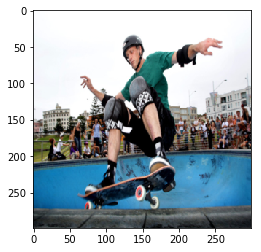

In [24]:
plt.imshow(img)

In [25]:
for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

a man riding a skateboard on a skateboard .
a man riding a skateboard on a skateboard .
a man on a skateboard doing a trick on a skateboard .
a man riding a skateboard on a skateboard .
a man riding a skateboard on a skateboard .
a man riding a skateboard on a skateboard .
a man riding a skateboard on a skateboard .
a man riding a skateboard on a skateboard .
a man riding a skateboard on a skateboard .
a man is riding a skateboard on a skateboard .


--2018-05-16 01:31:50--  http://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg
Распознаётся ccanimalclinic.com (ccanimalclinic.com)… 64.207.177.234
Подключение к ccanimalclinic.com (ccanimalclinic.com)|64.207.177.234|:80... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 200 OK
Длина: 106870 (104K) [image/jpeg]
Сохранение в: «data/img.jpg»

data/img.jpg        100%[===================>] 104,37K   279KB/s    за 0,4s    

2018-05-16 01:31:51 (279 KB/s) - «data/img.jpg» сохранён [106870/106870]



/Users/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


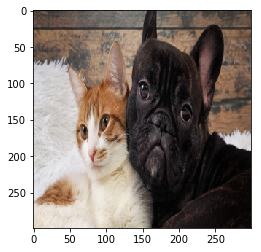

a cat sitting on a chair in a chair .
a cat laying on a chair with a cat .
a cat is standing next to a cat .
a cat laying on a bed with a cat .
a cat is laying on a bed with a cat .
a cat sitting on a bench in a chair .
a cat standing in a chair with a cat .
a black and white cat laying on a bed
a black and white cat sitting on a chair .
a cat is standing in front of a cat .


In [26]:
!wget http://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg -O data/img.jpg
img = plt.imread('data/img.jpg')
img = imresize(img, (299, 299)).astype('float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

# Demo
### Find at least 10 images to test it on.
* Seriously, that's part of an assignment. Go get at least 10 pictures to get captioned
* Make sure it works okay on __simple__ images before going to something more comples
* Photos, not animation/3d/drawings, unless you want to train CNN network on anime
* Mind the aspect ratio

/Users/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


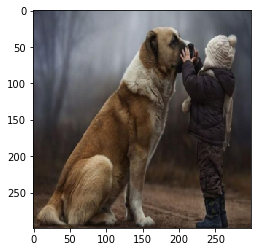

a dog is standing in a grassy area .
a dog is sitting on a bed with a dog .
a dog is standing in a room with a dog .
a dog is standing in a room with a dog .
a man is standing in a chair with a dog .
a dog is standing in a living room with a dog .
a dog is sitting on a bed with a dog .
a dog is standing in a chair with a dog .
a dog is sitting on a couch with a dog .
a dog is standing on a bed with a dog .


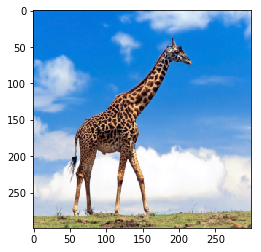

a giraffe standing in a field with a giraffe in the background .
a giraffe standing next to a fence in a field .
a giraffe standing in the grass with a giraffe .
a giraffe standing in a grassy field with trees .
a giraffe standing in the grass near a fence .
a giraffe standing in the grass near a fence .
a giraffe standing in the grass with a giraffe .
a giraffe standing in a field with a giraffe .
two giraffes standing in the grass in a field .
a giraffe standing in a field with a giraffe in the background .


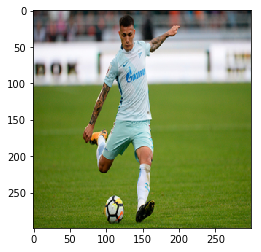

a man is playing frisbee in a field .
a man in a baseball uniform playing a game of a frisbee .
a young boy playing soccer on a field .
a man in a field playing a game of frisbee .
a man in a white shirt playing tennis on a court .
a man is playing frisbee in the air .
a man is playing a game of soccer .
a man in a white shirt playing soccer on a field .
a man in a field playing frisbee with a frisbee .
a man is playing frisbee in the air .


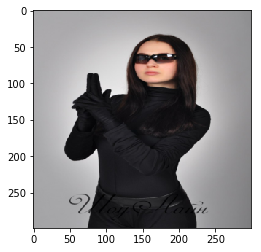

a woman is standing in front of a woman holding a cell phone .
a woman is standing in the rain holding a umbrella .
a woman is standing in the middle of a white umbrella .
a woman is standing in the rain holding a umbrella .
a woman holding a cell phone in a field .
a woman is standing in the rain with a woman in the background .
a woman is standing in front of a man holding a cell phone .
a woman in a red shirt and a woman standing in a hand .
a woman is holding a cell phone in a field .
a woman is standing in the rain with a woman in the background .


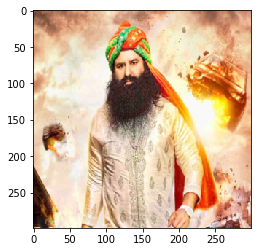

a woman in a red shirt and a red umbrella
a woman is holding a cell phone in the rain .
a woman holding a umbrella in a black umbrella .
a woman in a black shirt and a woman holding a umbrella .
a woman in a red shirt is holding a red umbrella .
a woman wearing a hat and a woman holding a cell phone .
a woman is standing in front of a woman holding a umbrella .
a woman holding a cell phone in front of a building .
a woman holding a pink umbrella in a park .
a man standing on a cell phone in front of a man .


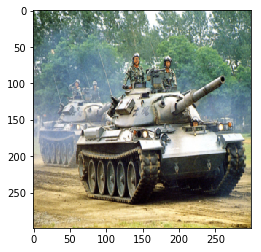

a group of people standing next to each other .
a couple of people are standing in the grass .
a group of people are standing in a field .
a group of people are standing in a field .
a couple of people standing on a field .
a group of people standing on a field .
a group of people standing in a kitchen .
a group of people standing in a field .
a group of people standing in a field
a group of people standing in a field .


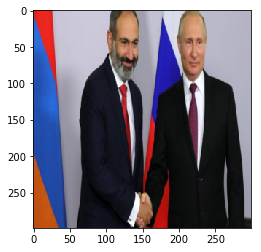

a man and a man standing in front of a man .
a man and a man in a suit and tie
a man in a suit and tie and a tie .
a man and a man in a suit and tie .
a man and a man and a woman standing in a room .
a man in a suit and tie standing in a room .
a man in a suit and tie standing in a room .
a man in a suit and tie standing in a room .
a man and a woman standing on a beach .
a man in a suit and tie standing next to a man .


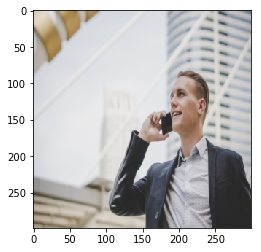

a man in a suit and tie in a room .
a man in a suit and a tie and a tie .
a man in a suit and tie standing in a room .
a man in a suit and a tie and a tie .
a man in a suit and tie standing next to a cell phone .
a man in a suit and tie standing next to a man .
a man in a suit and tie standing in a room .
a man in a suit and tie standing in a room .
a man in a suit and a tie and a tie .
a man in a suit and tie in a room .


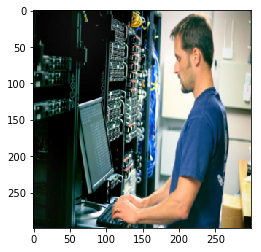

a man standing in a kitchen with a cell phone .
a man is standing in a kitchen with a wii controller .
a man in a kitchen with a cell phone .
a man is standing in a kitchen with a cell phone .
a man is standing in a kitchen with a cell phone .
a man is standing in a kitchen with a cell phone .
a man is standing in front of a kitchen .
a man in a kitchen with a white shirt and a cell phone .
a man standing in a kitchen with a cell phone .
a man standing in a kitchen with a wii controller .


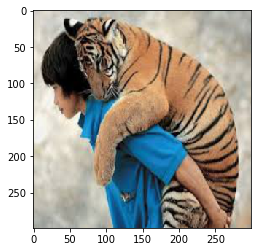

a man is standing on top of a wooden bench .
a man is standing in the middle of a large white bird .
a man standing on a dirt top of a road .
a man is standing in the middle of a white and white photo .
a man is standing in the middle of a white bowl .
a man standing in a blue shirt and a woman holding a banana .
a man is standing in the middle of a white photo .
a man is standing in the middle of a white plate .
a man is standing in a field with a frisbee .
a man is standing in the middle of a small child .


In [29]:
for i in range(10):
    img = plt.imread('images/' + str(i + 1) + '.jpg')
    img = imresize(img, (299, 299)).astype('float32') / 255.

    plt.imshow(img)
    plt.show()

    for i in range(10):
        print(' '.join(generate_caption(img, t=5.)[1:-1]))

### Now what?

Your model produces some captions but you still strive to improve it? You're damn right to do so. Here are some ideas that go beyond simply "stacking more layers". The options are listed easiest to hardest.

##### Subword level captioning
In the base version, we replace all rare words with UNKs which throws away a lot of information and reduces quality. A better way to deal with vocabulary size problem would be to use Byte-Pair Encoding

* BPE implementation you can use: [github_repo](https://github.com/rsennrich/subword-nmt). 
* Theory: https://arxiv.org/abs/1508.07909
* It was originally built for machine translation, but it should work with captioning just as well.

##### Attention
You can build better and more interpretable captioning model with attention.
* How it works: https://distill.pub/2016/augmented-rnns/
* One way of doing this in captioning: https://arxiv.org/abs/1502.03044
* You will have to create a dataset for attention with [this notebook](https://gist.github.com/justheuristic/11fd01f9c12c0bf960499580d104130b).

#### Reinforcement learning
* After your model has been pre-trained in a teacher forced way, you can tune for captioning-speific models like CIDEr.
* Tutorial on RL for sequence models: [practical_rl week8](https://github.com/yandexdataschool/Practical_RL/tree/master/week8_scst)
* Theory: https://arxiv.org/abs/1612.00563